In [1]:
from google.colab import drive 
drive.mount('/content/drive') 

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Robotics project I/Codes

/content/drive/MyDrive/Robotics project I/Codes


In [ ]:
!pip install pytorch-gradcam

In [ ]:
! pip install albumentations==0.4.6

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import albumentations as A
import sys
from implementations import *
from utils import *

## Data verification

Total number of green patches is:  375
Total number of red patches is:  374


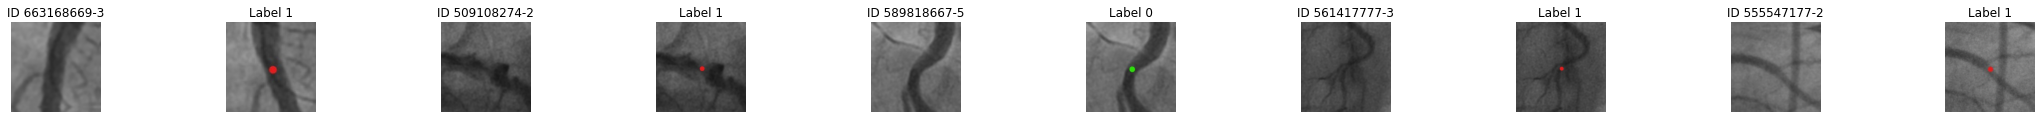

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
# Check if the data augmentation has been done properly
# Plots a subset of the patches with their corresponding labeled patch and patient ID, for a given data_file

base_folder = '/content/drive/MyDrive/Robotics project I/'
data_file = base_folder + 'Datasets/training_patches_augRed.npz'
f = np.load(data_file, allow_pickle=True)
X, Y, filenames, annotated_patches = f['X'], f['Y'], f['filenames'], f['annotated_patches']
Y=np.squeeze(Y)
print('Total number of green patches is: ',sum(Y==0))
print('Total number of red patches is: ',sum(Y==1))

plt.figure(figsize=(30, 70))
j= 0
for i in range(0,10):
  if(i%2==0):
    plt.subplot(50,10,j+1)
    plt.title('ID ' + os.path.splitext(filenames[i])[0])
    plt.imshow(f.f.X[i])
  if(i%2==1):
    plt.subplot(50,10,j+1)
    plt.title('Label '+ str(f.f.Y[i-1]))
    plt.imshow(f.f.annotated_patches[i-1])

  plt.axis("off")
  plt.tight_layout()
  j=j+1
plt.show()

## Weighted data loader

In [ ]:
# Load data from the weighted dataloader
trsf = A.Compose([A.MedianBlur(blur_limit=5, p=1),  
                  A.Rotate (limit=45, interpolation=1, border_mode=4, p=0.9),
                  A.ShiftScaleRotate (shift_limit=0.1, scale_limit=0, rotate_limit=0, interpolation=1, border_mode=4, p=0.9),
                  A.Resize(224, 224)
                  ]) 

base_folder = '/content/drive/MyDrive/Robotics project I/'
train_file = base_folder + 'Datasets/training_patches.npz'
val_file = base_folder + 'Datasets/validation_patches.npz'
test_file = base_folder + 'Datasets/test_patches.npz'

loader, weighted_prop_green = weighted_dataloader(train_file, val_file, trsf)  
weighted_prop_red = np.ones(np.shape(weighted_prop_green)) - weighted_prop_green 

Length of green patches class is:  375
Length of red patches class is:  150
# green patches / # red patches is: :  2.5
Proportion of red_patches from the dataloader with a weighted sampler is: 


In [ ]:
# Load data from the regular dataloader
data_train = CardioDataset(train_file, trsf, to_tensor = True) # need to load data to get indices
data_val = CardioDataset(val_file, trsf, to_tensor = True) # need to load data to get indices
dataloader = []
dataloader = {'train': DataLoader(data_train,  20, num_workers=0), 'val': DataLoader(data_val,  20, shuffle=True, num_workers=0)}
dataset_sizes = {'train': len(data_train), 'val': len(data_val)}
loader_prop_green = []
for sample in dataloader['train']:
  labels = sample['label']
  prop = (len(labels)-sum(labels))/len(labels)
  loader_prop_green.append(prop.item())
loader_prop_green = np.array(loader_prop_green)
loader_prop_red = np.ones(np.shape(loader_prop_green)) - loader_prop_green

In [ ]:
!pip install --upgrade matplotlib

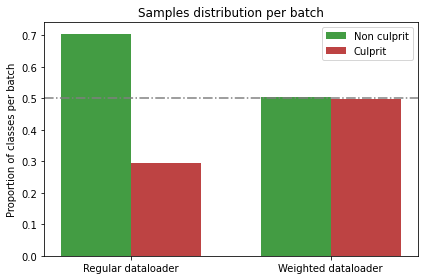

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Visualize the effect of the weighted loader

labels = ['Regular dataloader', 'Weighted dataloader']

green_means = []
green_means.append(np.mean(loader_prop_green))
green_means.append(np.mean(weighted_prop_green))

red_means = []
red_means.append(np.mean(loader_prop_red))
red_means.append(np.mean(weighted_prop_red))

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, green_means, width, label='Non culprit', color='forestgreen', alpha=0.85)
rects2 = ax.bar(x + width/2, red_means, width, label='Culprit', color = 'firebrick', alpha=0.85)

ax.set_ylabel('Proportion of classes per batch')
ax.set_title('Samples distribution per batch')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.axhline(y=0.5,color = 'grey', linestyle='-.', linewidth=1.5)

fig.tight_layout()

plt.show()

## Display patients views

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



True
Patient_ID:  509108274


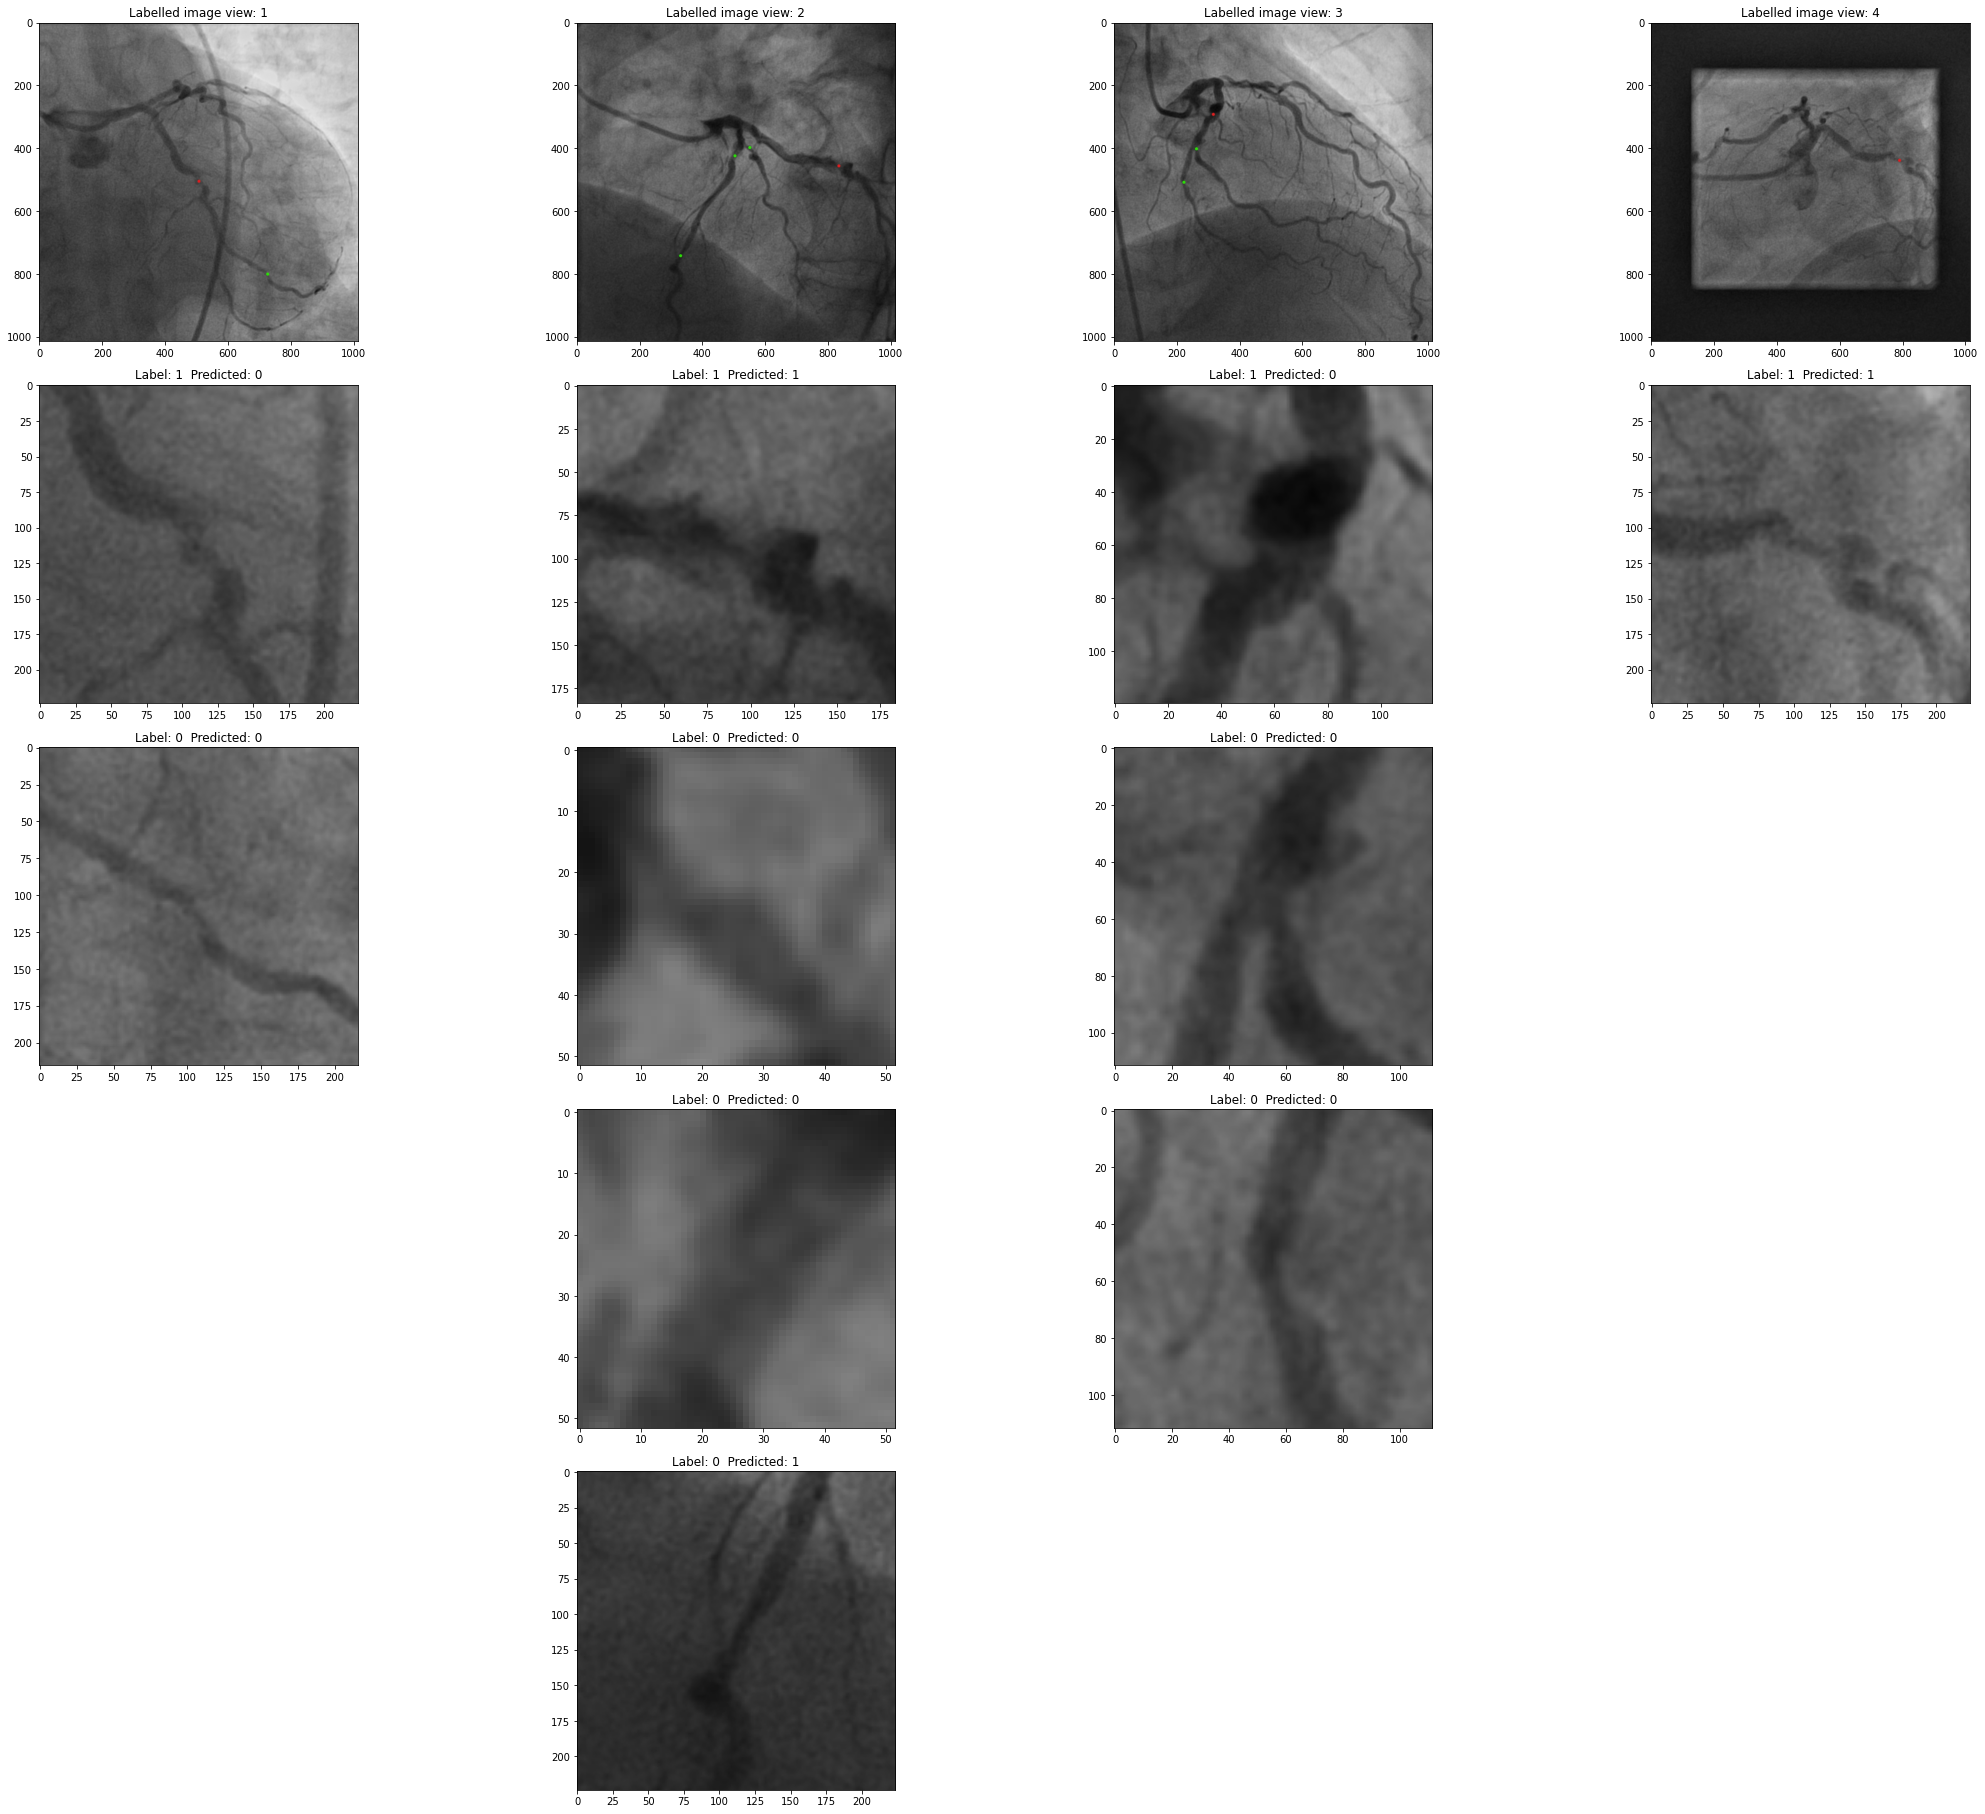

In [6]:
import os
import cv2
import torch 
import torchvision.transforms as T
from PIL import Image
from implementations import *

def display_patient_views(patient, path_to_model, culprit_only, raw = False):
  '''
  Displays different patch views, their corresponding labels and prediction for a given patient
  patient (string): patient ID, for example '509108274'
  path_to_model (string): path to the model to be used for patches evaluation
  culprit_only (boolean): specifies wether the function displays the red patches only (unique for each view) or red and green patches
  raw (boolean): specifies wether the function displays the raw image from which the patch has been extracted
  '''
  model = initialize_model('resnet18', 2, True)
  model.load_state_dict(torch.load(path_to_model))
  if torch.cuda.is_available():
      model.cuda()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model.eval()

  # Transform
  transform = T.Compose([
      T.Resize(224),
      T.ToTensor(),
      T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  # Get the number of views 
  views = []
  folder_raw = base_folder + 'Raw_Data/Raw'
  for f in os.listdir(folder_raw) :
    if(str(f[0:-6]) == patient):
      views.append(int(f[-5]))
  num_views = max(views)

  # Figure
  plt.figure(figsize=(30, 50))
  print('Patient_ID: ', patient)
  # Raw views
  if(raw):
    for f in os.listdir(folder_raw) :
      if(str(f[0:-6]) == patient):
        view = f[-5]
        img_raw = cv2.imread(os.path.join(folder_raw, f))
        img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
        plt.subplot(10,num_views,int(view))
        #plt.title('Misclassified: '+ os.path.splitext(filenames_p[i])[0])
        plt.title('Raw image view: '+ view)
        plt.imshow(img_raw)
  
  # Labelled views 
  folder_labelled = base_folder + 'Raw_Data/Labelled'
  for f in os.listdir(folder_labelled) :
    if(str(f[5:-9]) == patient):
      view = f[-8]
      img_lab = cv2.imread(os.path.join(folder_labelled, f))
      img_lab = cv2.cvtColor(img_lab, cv2.COLOR_BGR2RGB)
      plot = int(view) + num_views
      plt.subplot(10,num_views,plot)
      #plt.title('Misclassified: '+ os.path.splitext(filenames_p[i])[0])
      plt.title('Labelled image view: '+ view)
      plt.imshow(img_lab)

  # Different paches generation with the corresponding view, label and prediction 
  patches_file = base_folder + 'Datasets/dataset_patches.npz'
  f = np.load(patches_file, allow_pickle=True)
  X, Y, filenames, annotated = f['X'], f['Y'], f['filenames'], f['annotated_patches']
  Y=np.squeeze(Y)

  # Find all the rows related to a given patient and store the corresponding view
  indices = []
  patches_views = []
  for i, f  in enumerate(filenames):
    if(str(f[0:-6]) == patient):
      indices.append(i)
      patches_views.append(f[-5])
  idx = np.argsort(patches_views)

  indices = np.array(indices)[idx]
  patches_views = np.array(patches_views)[idx]

  # For each view plot the patch, label and prediction
  old_view = 1
  cnt = 0
  for i, view  in enumerate(patches_views):

    img = X[indices[i]]

    input = Image.fromarray(X[indices[i]])
    input = transform(input).unsqueeze(0)
    input = input.to(device)

    target = torch.tensor(Y[indices[i]])
    target =target.to(device) 
    # Display red patches only if culprit_only is True
    if(target.item() == 0 and culprit_only):
       continue
    prediction = model(input)
    prediction = prediction.argmax(axis = 1)

    error = prediction -target

    if(view == old_view):
      cnt = cnt+1
    else:
      cnt = 1
      old_view = view

    plot = int(view) + (1+cnt)*num_views
    plt.subplot(10,num_views,plot)
    plt.title('Label: '+ str(target.item()) + '  Predicted: '+ str(prediction.item()))
    plt.imshow(img)
    plt.tight_layout()
    plt.savefig('Patient_results.png')
  return 

# Inputs 
patient = '509108274'
base_folder = '/content/drive/MyDrive/Robotics project I/'
path_to_model = '/content/drive/MyDrive/Robotics project I/Models/model_pretrained.pth'
culprit_only = False
display_patient_views(patient, path_to_model, culprit_only, raw=False)